# Decision Tree Exercises

In [1]:
import numpy as np
import pandas as pd
import acquire
import prepare
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
import graphviz
from graphviz import Graph
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def split(df, stratify_by=None):
    """
    Crude train, validate, test split
    To stratify, send in a column name for the stratify_by argument
    """

    if stratify_by == None:
        train, test = train_test_split(df, test_size=.2, random_state=123)
        train, validate = train_test_split(train, test_size=.3, random_state=123)
    else:
        train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
        train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])

    return train, validate, test



In [3]:
# Acquire
df = acquire.get_titanic_data()
df.head()



,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,None,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,None,Southampton,1


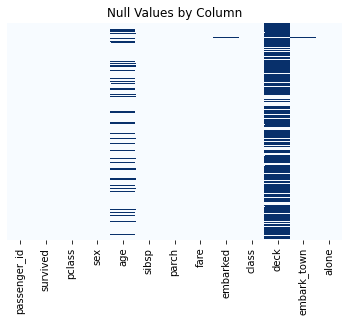

In [4]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap='Blues')

plt.title('Null Values by Column')
plt.show()



In [5]:
df.isna().sum()



passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [6]:
#encode and concat
get_dummies = pd.get_dummies(df[['embark_town', 'sex']], drop_first=True)
get_dummies.sample(5)
df = pd.concat([df, get_dummies], axis=1)
df.sample(2)



,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
671,671,0,1,male,31.0,1,0,52.00,S,First,B,Southampton,0,0,1,1
214,214,0,3,male,NaN,1,0,7.75,Q,Third,None,Queenstown,0,1,0,1


In [8]:
#drop columns
df = df.drop(columns=['deck', 'sex', 'passenger_id', 'embarked','embark_town', 'age', 'class'])


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   survived                 891 non-null    int64  
 1   pclass                   891 non-null    int64  
 2   sibsp                    891 non-null    int64  
 3   parch                    891 non-null    int64  
 4   fare                     891 non-null    float64
 5   alone                    891 non-null    int64  
 6   embark_town_Queenstown   891 non-null    uint8  
 7   embark_town_Southampton  891 non-null    uint8  
 8   sex_male                 891 non-null    uint8  
dtypes: float64(1), int64(5), uint8(3)
memory usage: 44.5 KB


In [9]:
def train_validate_test_split(df, seed=123):
    train_and_validate, test = train_test_split(
        df, test_size=0.2, random_state=seed, stratify=df.survived
    )
    train, validate = train_test_split(
        train_and_validate,
        test_size=0.3,
        random_state=seed,
        stratify=train_and_validate.survived,
    )
    return train, validate, test

In [10]:
train, validate, test = train_validate_test_split(df)
train.head()

,survived,pclass,sibsp,parch,fare,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
583,0,1,0,0,40.1250,1,0,0,1
165,1,3,0,2,20.5250,0,0,1,1
50,0,3,4,1,39.6875,0,0,1,1
259,1,2,0,1,26.0000,0,0,1,0
306,1,1,0,0,110.8833,1,0,0,0


In [11]:
train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.survived)



In [12]:
train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123, 
                                   stratify=train_validate.survived)


In [13]:
# We will be attempting to make a decision tree classifier model that will predict survival on the titanic that performs better than the baseline


In [14]:
train.head()



,survived,pclass,sibsp,parch,fare,alone,embark_town_Queenstown,embark_town_Southampton,sex_male
583,0,1,0,0,40.1250,1,0,0,1
165,1,3,0,2,20.5250,0,0,1,1
50,0,3,4,1,39.6875,0,0,1,1
259,1,2,0,1,26.0000,0,0,1,0
306,1,1,0,0,110.8833,1,0,0,0


### 1. What is your baseline prediction? What is your baseline accuracy? remember: your baseline prediction for a classification problem is predicting the most prevelant class in the training dataset (the mode). When you make those predictions, what is your accuracy? This is your baseline accuracy.

In [15]:
#get mode from survial counts
train.survived.value_counts()
#baseline is 0 = did not survive



0    307
1    191
Name: survived, dtype: int64

In [16]:
train['baseline'] = 0 
#column that is just zeros bc that is the assumption determined from the mode


<ipython-input-16-a81ec0b7bf29>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['baseline'] = 0


In [17]:
print(f'Baseline Accuracy is {(train.baseline == train.survived).mean():.3}')



Baseline Accuracy is 0.616


### 2. Fit the decision tree classifier to your training sample and transform (i.e. make predictions on the training sample)

In [18]:
#create model then fit
clf_1 = DecisionTreeClassifier()

In [19]:
#max dept default to compare against



In [20]:
train.drop(columns='baseline', inplace=True)



/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [21]:
X_train = train.drop(columns='survived') #everything in the df that is not
y_train = train.survived



In [22]:
clf_1.fit(X_train, y_train)



DecisionTreeClassifier()

In [24]:
y_pred = clf_1.predict(X_train)

In [25]:
pd.Series(y_pred).value_counts()

0    330
1    168
dtype: int64

In [ ]:
#model score accuracy

In [27]:
accuracy = clf_1.score(X_train, y_train)
accuracy

0.9457831325301205

### 3. Evaluate your in-sample results using the model score, confusion matrix, and classification report.

In [ ]:
#confusion matrix

In [28]:
conf = confusion_matrix(y_train, y_pred)

In [29]:
conf

array([[305,   2],
       [ 25, 166]])

### 4. Compute: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [30]:
class_report = classification_report(y_train, y_pred, output_dict=True)

In [31]:
class_report

{'0': {'precision': 0.9242424242424242,
  'recall': 0.993485342019544,
  'f1-score': 0.9576138147566718,
  'support': 307},
 '1': {'precision': 0.9880952380952381,
  'recall': 0.8691099476439791,
  'f1-score': 0.9247910863509748,
  'support': 191},
 'accuracy': 0.9457831325301205,
 'macro avg': {'precision': 0.9561688311688312,
  'recall': 0.9312976448317616,
  'f1-score': 0.9412024505538233,
  'support': 498},
 'weighted avg': {'precision': 0.9487321580695075,
  'recall': 0.9457831325301205,
  'f1-score': 0.9450251779585028,
  'support': 498}}

In [32]:
pd.DataFrame(class_report).rename({'0': 'death', '1': 'survived'}).T

,precision,recall,f1-score,support
0,0.924242,0.993485,0.957614,307.000000
1,0.988095,0.869110,0.924791,191.000000
accuracy,0.945783,0.945783,0.945783,0.945783
macro avg,0.956169,0.931298,0.941202,498.000000
weighted avg,0.948732,0.945783,0.945025,498.000000


In [41]:
conf_df = pd.DataFrame(conf, columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])

In [42]:
conf_df

,predict_death,predict_survive
actual_death,305,2
actual_survive,25,166


In [43]:
rubric_df = pd.DataFrame([['true negative', 'false positive'],['false negative', 'true positive']], columns=['predict_death', 'predict_survive'], index=['actual_death', 'actual_survive'])
rubric_df

,predict_death,predict_survive
actual_death,true negative,false positive
actual_survive,false negative,true positive


In [44]:
joined = pd.concat([conf_df, rubric_df], axis=1)

In [45]:
joined

,predict_death,predict_survive,predict_death,predict_survive
actual_death,305,2,true negative,false positive
actual_survive,25,166,false negative,true positive


In [47]:
# create a function to calculate these metrics
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report


In [48]:
report_df = get_metrics_binary(clf_1)


    The accuracy for our model is 0.9458
    The True Positive Rate is 0.869, The False Positive Rate is 0.00651,
    The True Negative Rate is 0.993, and the False Negative Rate is 0.131
    


### 5. Run through steps 2-4 using a different max_depth value.

In [49]:
#clf_2
clf_2 = DecisionTreeClassifier(max_depth=3)

In [ ]:
#fit the model

In [50]:
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [51]:
y_pred = clf_2.predict(X_train)

### 6. Which model performs better on your in-sample data?

In [52]:
report_df = get_metrics_binary(clf_2)


    The accuracy for our model is 0.8233
    The True Positive Rate is 0.702, The False Positive Rate is 0.101,
    The True Negative Rate is 0.899, and the False Negative Rate is 0.298
    


In [53]:
report_df

,precision,recall,f1-score,support
0,0.828829,0.899023,0.862500,307.000000
1,0.812121,0.701571,0.752809,191.000000
accuracy,0.823293,0.823293,0.823293,0.823293
macro avg,0.820475,0.800297,0.807654,498.000000
weighted avg,0.822421,0.823293,0.820430,498.000000


### 7. Which model performs best on your out-of-sample data, the validate set?

In [55]:
# get predictions for our validation sets
y_val_pred_1 = clf_1.predict(validate.drop(columns='survived'))
y_val_pred_2 = clf_2.predict(validate.drop(columns='survived'))


In [57]:
# get validation accuracy
accuracy_v_1 = clf_1.score(validate.drop(columns='survived'), validate.survived)
accuracy_v_2 = clf_2.score(validate.drop(columns='survived'), validate.survived)



In [58]:
accuracy_v_1


0.7523364485981309

In [59]:
accuracy_v_2


0.7850467289719626

In [61]:
dot_data = export_graphviz(clf_2, feature_names= X_train.columns, rounded=True, filled=True, out_file=None)
graph = graphviz.Source(dot_data)

In [62]:
graph.render('titanic_model_1_tree', view=True)

'titanic_model_1_tree.pdf'

# Random Forest

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 1. Fit the Random Forest classifier to your training sample and transform (i.e. make predictions on the training sample) setting the random_state accordingly and setting min_samples_leaf = 1 and max_depth = 10.

In [65]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [66]:
#fit the model
rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=123)

In [67]:
#feature importance
print(rf.feature_importances_)


[0.09612117 0.07037045 0.05072663 0.38133035 0.02286695 0.01572535
 0.02845606 0.33440304]


In [68]:
#make predictions
y_pred = rf.predict(X_train)


In [69]:
#estimate probability
y_pred_proba = rf.predict_proba(X_train)


### 2. Evaluate your results using the model score, confusion matrix, and classification report.

In [70]:
#compute the accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.94


In [71]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))


[[302   5]
 [ 23 168]]


In [72]:
#classification report
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.98      0.96       307
           1       0.97      0.88      0.92       191

    accuracy                           0.94       498
   macro avg       0.95      0.93      0.94       498
weighted avg       0.95      0.94      0.94       498



### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

In [73]:
def get_metrics_binary(clf):
    '''
    get_metrics_binary takes in a confusion matrix (cnf) for a binary classifier and prints out metrics based on
    values in variables named X_train, y_train, and y_pred.
    
    return: a classification report as a transposed DataFrame
    '''
    accuracy = clf.score(X_train, y_train)
    class_report = pd.DataFrame(classification_report(y_train, y_pred, output_dict=True)).T
    conf = confusion_matrix(y_train, y_pred)
    tpr = conf[1][1] / conf[1].sum()
    fpr = conf[0][1] / conf[0].sum()
    tnr = conf[0][0] / conf[0].sum()
    fnr = conf[1][0] / conf[1].sum()
    print(f'''
    The accuracy for our model is {accuracy:.4}
    The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
    The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
    ''')
    return class_report


In [74]:
rf_report = get_metrics_binary(rf)


    The accuracy for our model is 0.9438
    The True Positive Rate is 0.88, The False Positive Rate is 0.0163,
    The True Negative Rate is 0.984, and the False Negative Rate is 0.12
    


### 4. Run through steps increasing your min_samples_leaf and decreasing your max_depth.

In [75]:
rf_2 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

In [76]:
#fit the model
rf_2.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=3, random_state=123)

In [77]:
#feature importance
print(rf.feature_importances_)

[0.09612117 0.07037045 0.05072663 0.38133035 0.02286695 0.01572535
 0.02845606 0.33440304]


In [78]:
#make predictions
y_pred = rf.predict(X_train)

In [79]:
#estimate probability
y_pred_proba = rf.predict_proba(X_train)

In [80]:
#compute the accuracy
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.94


In [81]:
#confusion matrix
print(confusion_matrix(y_train, y_pred))

[[302   5]
 [ 23 168]]


In [82]:
#classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       307
           1       0.97      0.88      0.92       191

    accuracy                           0.94       498
   macro avg       0.95      0.93      0.94       498
weighted avg       0.95      0.94      0.94       498



In [83]:
rf_report = get_metrics_binary(rf_2)


    The accuracy for our model is 0.8514
    The True Positive Rate is 0.88, The False Positive Rate is 0.0163,
    The True Negative Rate is 0.984, and the False Negative Rate is 0.12
    


In [84]:
rf_report = get_metrics_binary(rf)


    The accuracy for our model is 0.9438
    The True Positive Rate is 0.88, The False Positive Rate is 0.0163,
    The True Negative Rate is 0.984, and the False Negative Rate is 0.12
    


### 5. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

In [85]:
# get predictions for our validation sets
y_val_pred_1 = rf.predict(validate.drop(columns='survived'))
y_val_pred_2 = rf_2.predict(validate.drop(columns='survived'))


In [86]:
# get validation accuracy
accuracy_v_1 = rf.score(validate.drop(columns='survived'), validate.survived)
accuracy_v_2 = rf_2.score(validate.drop(columns='survived'), validate.survived)



### After making a few models, which one has the best performance (or closest metrics) on both train and validate?

In [ ]:
# accuracy: the total number of correct assessed predictions out of all observations predicted
# TPR:  Sensitivity: Recall for the positive class
(tp / (tp + fn))
#precision
(tp / (tp + fp))

In [87]:
accuracy_v_1

0.7710280373831776

In [88]:
accuracy_v_2

0.8037383177570093

The second model is less accurate than the first.  The first model performs better on in sample data, and the second one performs better on out of sample data.

# K-Nearest Neighbor

### 1. Fit a K-Nearest Neighbors classifier to your training sample and transform (i.e. make predictions on the training sample)

### 2. Evaluate your results using the model score, confusion matrix, and classification report.

### 3. Print and clearly label the following: Accuracy, true positive rate, false positive rate, true negative rate, false negative rate, precision, recall, f1-score, and support.

### 4. Run through steps 2-4 setting k to 10

### 5. Run through setps 2-4 setting k to 20

### 6. What are the differences in the evaluation metrics? Which performs better on your in-sample data? Why?

### 7. Which model performs best on our out-of-sample data from validate?